In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
dataset = 'ssc'
deletion_dir = '../deletions_%s' % dataset
ped_file = '../data/ssc.ped'
#ped_file = '../data/Ancestry Data files/AncestryDNA.ped'

#deletion_dir = '../deletions_spark_exome'
#ped_file = '../data/spark_jae_adj.ped'

chroms = [str(x) for x in range(1, 23)]

In [5]:
all_deletions = []

for chrom in chroms:
    print(chrom, end=' ')
    
    with open('%s/chr.%s.deletions.json' % (deletion_dir, chrom), 'r') as f:
        deletions = json.load(f)
    all_deletions.extend(deletions)
                          
                          

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [6]:
# pull cytobands
intervals = []

with open('../data/cytoBand.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            intervals.append((pieces[0][3:], pieces[3], int(pieces[1]), int(pieces[2]), pieces[4]))
intervals = sorted(intervals, key=lambda x: (int(x[0]), x[2]))

interval_chroms = np.array([int(x[0]) for x in intervals])
first_chrom = [0] + np.where(interval_chroms[1:] != interval_chroms[:-1])[0].tolist()

# filter deletions that go through the centromere
centromeres = [x for x in intervals if x[-1] == 'acen']
centromere_deletions = set()
for i, d in enumerate(all_deletions):
    for chrom, _, start_pos, end_pos, _ in centromeres:
        if d['chrom'] == chrom:
            if d['start_pos'] >= start_pos and d['start_pos'] <= end_pos:
                centromere_deletions.add(i)
            elif d['end_pos'] >= start_pos and d['end_pos'] <= end_pos:
                centromere_deletions.add(i)
            elif d['start_pos'] <= start_pos and d['end_pos'] >= end_pos:
                centromere_deletions.add(i)
print('centromere deletions', len(centromere_deletions)) 

all_deletions = [d for i, d in enumerate(all_deletions) if i not in centromere_deletions]

centromere deletions 433


In [7]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		if len(pieces) >= 6:
			fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
			child_id_to_affected[child_id] = disease_status
			child_id_to_sex[child_id] = sex
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 2076


# Deletion lengths

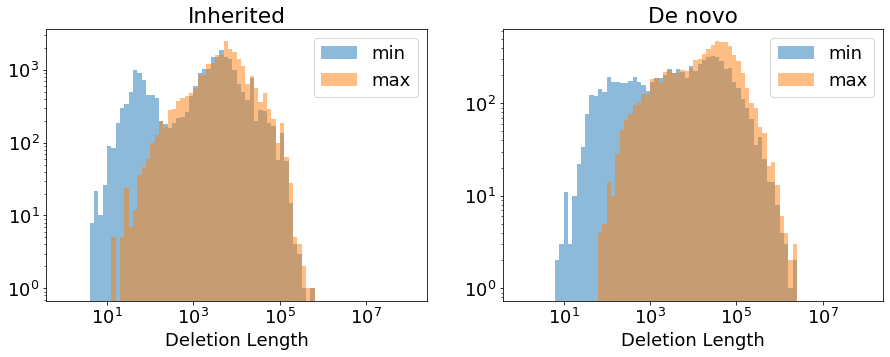

In [8]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
all_lengths = [d['length'] for d in all_deletions if not d['is_denovo']]
#print(np.min(all_lengths), np.max(all_lengths), np.median(all_lengths))
plt.hist(np.clip(all_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), log=True, alpha=0.5, label='min')
all_opt_lengths = [d['opt_end_pos']-d['opt_start_pos'] for d in all_deletions if not d['is_denovo']]
plt.hist(np.clip(all_opt_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), log=True, alpha=0.5, label='max')
plt.xscale('log')
plt.xlabel('Deletion Length')
plt.title('Inherited')
plt.legend()

plt.subplot(1, 2, 2)
all_lengths = [d['length'] for d in all_deletions if d['is_denovo']]
#print(np.min(all_lengths), np.max(all_lengths), np.median(all_lengths))
plt.hist(np.clip(all_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), log=True, alpha=0.5, label='min')
all_opt_lengths = [d['opt_end_pos']-d['opt_start_pos'] for d in all_deletions if d['is_denovo']]
plt.hist(np.clip(all_opt_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), log=True, alpha=0.5, label='max')
plt.xscale('log')
plt.xlabel('Deletion Length')
plt.title('De novo')
plt.legend()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


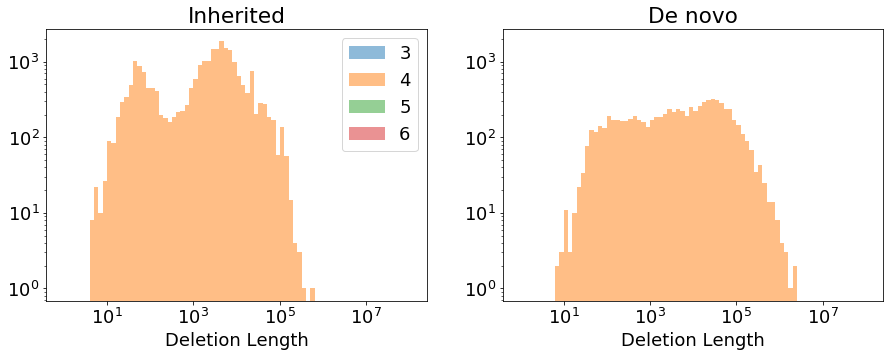

In [9]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
for famsize in [3, 4, 5, 6]:
    all_lengths = [d['length'] for d in all_deletions if not d['is_denovo'] and d['family_size'] == famsize]
    plt.hist(np.clip(all_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), log=True, alpha=0.5, label=str(famsize))
plt.xscale('log')
plt.xlabel('Deletion Length')
plt.title('Inherited')
plt.legend()

plt.subplot(1, 2, 2, sharey=ax)
for famsize in [3, 4, 5, 6]:
    all_lengths = [d['length'] for d in all_deletions if d['is_denovo'] and d['family_size'] == famsize]
    plt.hist(np.clip(all_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), log=True, alpha=0.5, label=str(famsize))
plt.xscale('log')
plt.xlabel('Deletion Length')
plt.title('De novo')
plt.show()

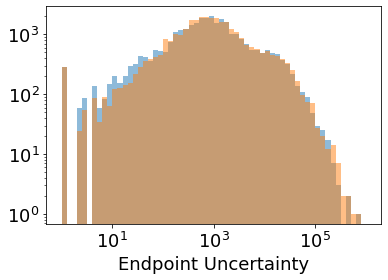

In [10]:
start_uncertainty = [d['start_pos']-d['opt_start_pos'] for d in all_deletions]
plt.hist(np.clip(start_uncertainty, 1, 10**6), bins=np.power(10.0, np.arange(0, 6.1, 0.1)), log=True, alpha=0.5)
end_uncertainty = [d['opt_end_pos']-d['end_pos'] for d in all_deletions]
plt.hist(np.clip(end_uncertainty, 1, 10**6), bins=np.power(10.0, np.arange(0, 6.1, 0.1)), log=True, alpha=0.5)

plt.xscale('log')
plt.xlabel('Endpoint Uncertainty')
plt.show()

# Deletions per individual

In [11]:
child_to_inh_mat_dels = defaultdict(int)
child_to_inh_pat_dels = defaultdict(int)
child_to_denovo_mat_dels = defaultdict(int)
child_to_denovo_pat_dels = defaultdict(int)

mom_to_inh_dels = defaultdict(int)
mom_to_denovo_dels = defaultdict(int)
dad_to_inh_dels = defaultdict(int)
dad_to_denovo_dels = defaultdict(int)

ind_to_familysize = dict()

for d in all_deletions:
    if d['is_denovo'] and d['is_mat']:
        for child in d['trans']:
            child_to_denovo_mat_dels[child] += d['length']
            ind_to_familysize[child] = d['family_size']
        mom_to_denovo_dels[d['mother']] += d['length']
        ind_to_familysize[d['mother']] = d['family_size']
    elif d['is_denovo'] and d['is_pat']:
        for child in d['trans']:
            child_to_denovo_pat_dels[child] += d['length']
            ind_to_familysize[child] = d['family_size']
        dad_to_denovo_dels[d['father']] += d['length']
        ind_to_familysize[d['father']] = d['family_size']
    elif not d['is_denovo'] and d['is_mat']:
        for child in d['trans']:
            child_to_inh_mat_dels[child] += d['length']
            ind_to_familysize[child] = d['family_size']
        mom_to_inh_dels[d['mother']] += d['length']
        ind_to_familysize[d['mother']] = d['family_size']
    elif not d['is_denovo'] and d['is_pat']:
        for child in d['trans']:
            child_to_inh_pat_dels[child] += d['length']
            ind_to_familysize[child] = d['family_size']
        dad_to_inh_dels[d['father']] += d['length']
        ind_to_familysize[d['father']] = d['family_size']

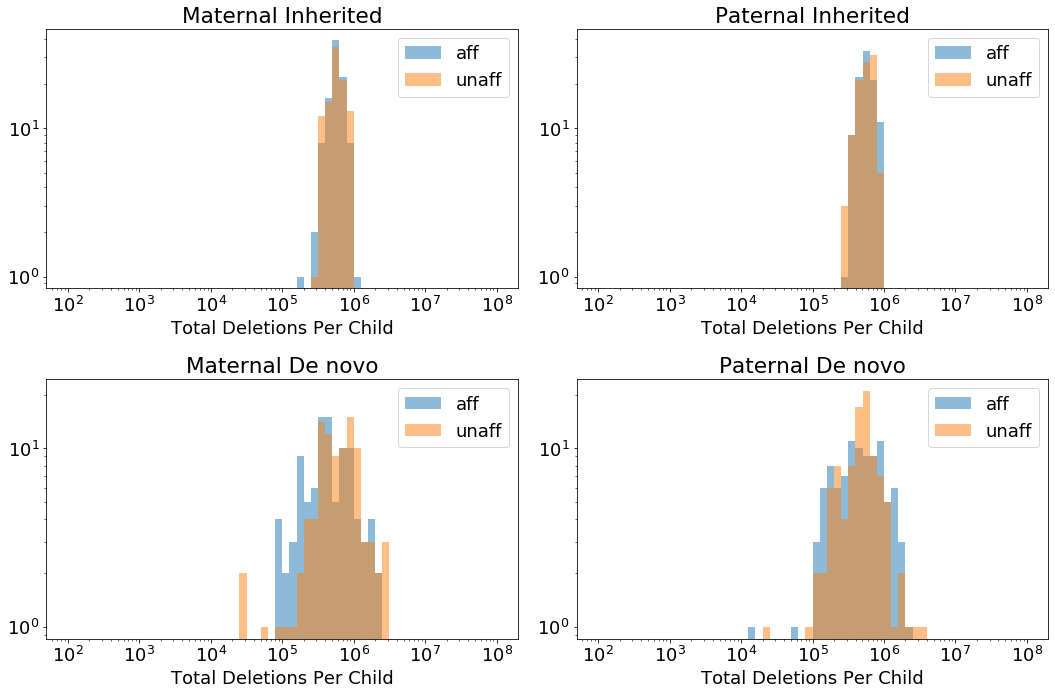

In [12]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 10))

bins = np.power(10.0, np.arange(2, 8.1, 0.1))

ax = plt.subplot(2, 2, 1)
plt.hist(np.clip([v for x, v in child_to_inh_mat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
plt.hist(np.clip([v for x, v in child_to_inh_mat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
plt.xscale('log')
plt.xlabel('Total Deletions Per Child')
plt.title('Maternal Inherited')
plt.legend()

plt.subplot(2, 2, 2, sharey=ax)
plt.hist(np.clip([v for x, v in child_to_inh_pat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
plt.hist(np.clip([v for x, v in child_to_inh_pat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
plt.xscale('log')
plt.xlabel('Total Deletions Per Child')
plt.title('Paternal Inherited')
plt.legend()

ax = plt.subplot(2, 2, 3)
plt.hist(np.clip([v for x, v in child_to_denovo_mat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
plt.hist(np.clip([v for x, v in child_to_denovo_mat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
plt.xscale('log')
plt.xlabel('Total Deletions Per Child')
plt.title('Maternal De novo')
plt.legend()

plt.subplot(2, 2, 4, sharey=ax)
plt.hist(np.clip([v for x, v in child_to_denovo_pat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
plt.hist(np.clip([v for x, v in child_to_denovo_pat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
plt.xscale('log')
plt.xlabel('Total Deletions Per Child')
plt.title('Paternal De novo')
plt.legend()


plt.tight_layout()
plt.show()

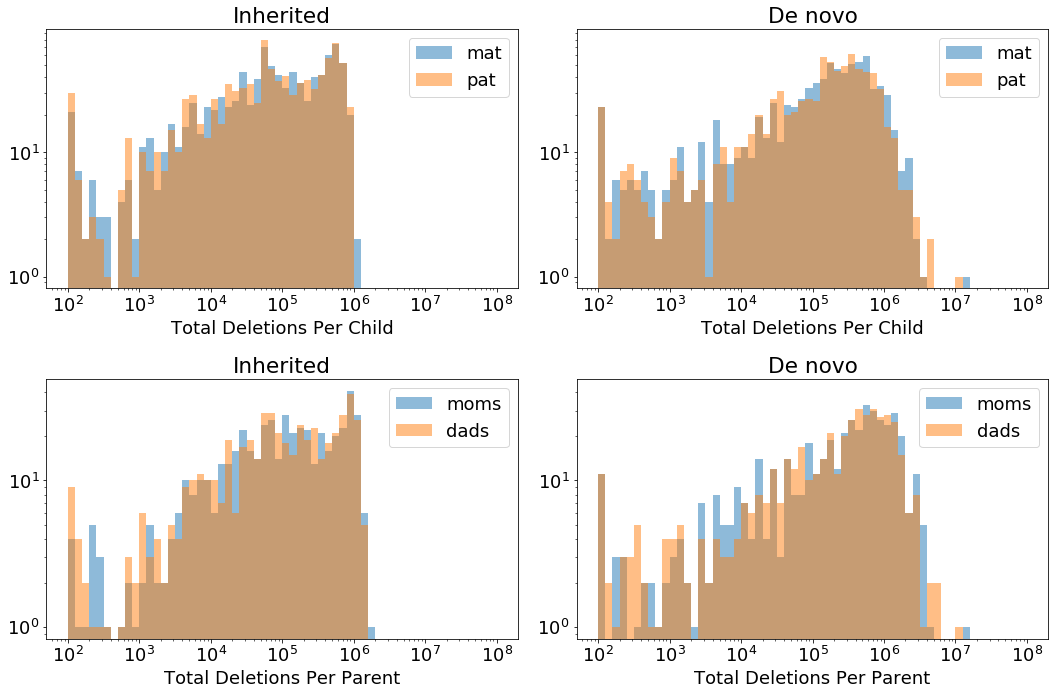

In [53]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 10))

bins = np.power(10.0, np.arange(2, 8.1, 0.1))

ax = plt.subplot(2, 2, 1)
plt.hist(np.clip(list(child_to_inh_mat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='mat')
plt.hist(np.clip(list(child_to_inh_pat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='pat')
plt.xscale('log')
plt.xlabel('Total Deletions Per Child')
plt.title('Inherited')
plt.legend()

plt.subplot(2, 2, 2, sharey=ax)
plt.hist(np.clip(list(child_to_denovo_mat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='mat')
plt.hist(np.clip(list(child_to_denovo_pat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='pat')
plt.xscale('log')
plt.xlabel('Total Deletions Per Child')
plt.title('De novo')
plt.legend()

ax = plt.subplot(2, 2, 3)
plt.hist(np.clip(list(mom_to_inh_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='moms')
plt.hist(np.clip(list(dad_to_inh_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='dads')
plt.xscale('log')
plt.xlabel('Total Deletions Per Parent')
plt.title('Inherited')
plt.legend()

plt.subplot(2, 2, 4, sharey=ax)
plt.hist(np.clip(list(mom_to_denovo_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='moms')
plt.hist(np.clip(list(dad_to_denovo_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='dads')
plt.xscale('log')
plt.xlabel('Total Deletions Per Parent')
plt.title('De novo')
plt.legend()

plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


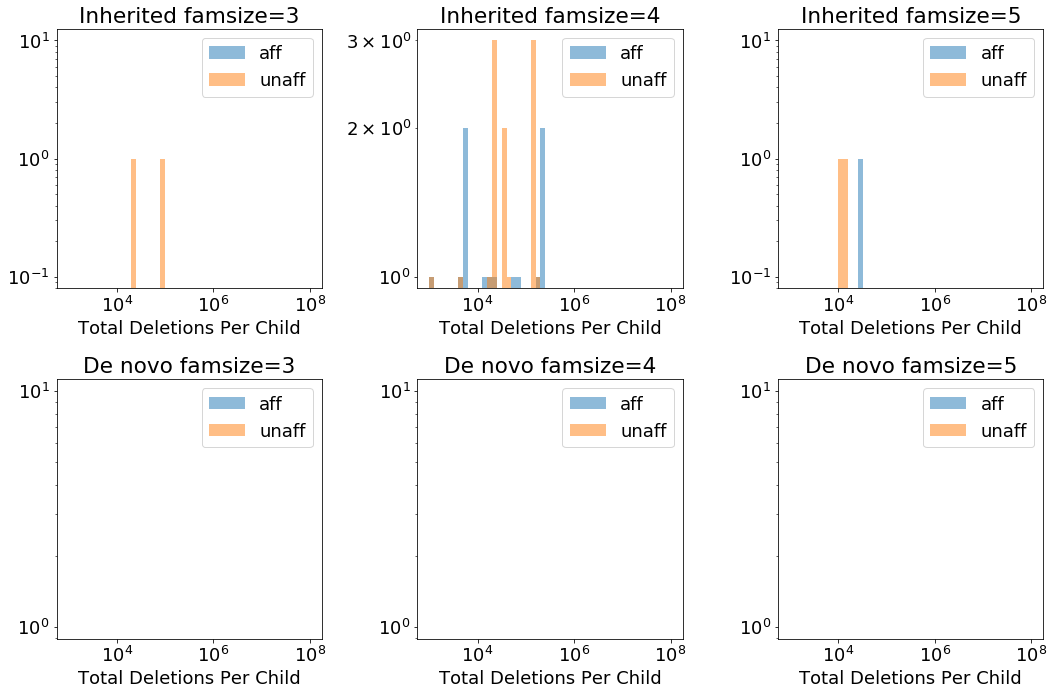

In [40]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 10))

bins = np.power(10.0, np.arange(3, 8.1, 0.1))

for famsize in [3, 4, 5]:
    plt.subplot(2, 3, famsize-2)
    plt.hist(np.clip([v for x, v in child_to_inh_mat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='2'] + [v for x, v in child_to_inh_pat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
    plt.hist(np.clip([v for x, v in child_to_inh_mat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='1'] + [v for x, v in child_to_inh_pat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
    plt.xscale('log')
    plt.xlabel('Total Deletions Per Child')
    plt.title('Inherited famsize=%d' % famsize)
    plt.legend()

    plt.subplot(2, 3, famsize+1)
    plt.hist(np.clip([v for x, v in child_to_denovo_mat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='2'] + [v for x, v in child_to_denovo_pat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
    plt.hist(np.clip([v for x, v in child_to_denovo_mat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='1'] + [v for x, v in child_to_denovo_pat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
    plt.xscale('log')
    plt.xlabel('Total Deletions Per Child')
    plt.title('De novo famsize=%d' % famsize)
    plt.legend()



plt.tight_layout()
plt.show()

In [41]:
deletions_of_interest = [d for d in all_deletions if d['length']>10**6 and not d['is_denovo']]

with open('../deletions_to_validate/%s_inherited.json' % dataset, 'w+') as f:
    json.dump(deletions_of_interest, f, indent=4)

for d in deletions_of_interest:
    print('%s:%d-%d' % (d['chrom'], d['start_pos'], d['end_pos']))
    print(d)

In [31]:
deletions_of_interest = [d for d in all_deletions if d['length']>10**7 and d['is_denovo']]

with open('../deletions_to_validate/%s_denovo.json' % dataset, 'w+') as f:
    json.dump(deletions_of_interest, f, indent=4)

for d in deletions_of_interest:
    print('%s:%d-%d' % (d['chrom'], d['start_pos'], d['end_pos']))
    print(d)

In [32]:
deletions_of_interest = [d for d in all_deletions if d['phase_length']>2*10**4 and d['is_denovo']]

with open('../deletions_to_validate/%s_denovo_confident.json' % dataset, 'w+') as f:
    json.dump(deletions_of_interest, f, indent=4)

for d in deletions_of_interest:
    print('%s:%d-%d' % (d['chrom'], d['start_pos'], d['end_pos']))
    print(d)

In [33]:
deletions_of_interest = [d for d in all_deletions if d['phase_length']>2*10**3 and not d['is_denovo']]

with open('../deletions_to_validate/%s_inherited_confident.json' % dataset, 'w+') as f:
    json.dump(deletions_of_interest, f, indent=4)

for d in deletions_of_interest:
    print('%s:%d-%d' % (d['chrom'], d['start_pos'], d['end_pos']))
    print(d)